In [1]:
"""
Imports needed

Several .py required to be in same folder as notebook:
ceda_download.py, cross_wavelet.py, distance_matrix.py, download_midas_data.py, july21_get_all_data.py,
july21_get_cosmos_data.py, july_21_get_flux_data.py, july21_get_midas_data.py, rf.py
"""
%matplotlib notebook
from download_midas_data import download_midas_full
from july21_get_all_data import get_july21_all_data
from sklearn import preprocessing
from cross_wavelet import cross_wavelet
from distance_matrix import *
from rf import plot_cols_4_cols_importances, plot_combi_summed_importances, plot_n_groups_importances
import itertools

In [9]:
"""
Run this cell to download MIDAS Data for 2021. The files are saved in the correct file structure for the next cell.

NOTE: A CEDA account with access to the full MIDAS datset is required to run this cell
"""
download_midas_full([2021],'Hanger Field July 2021/MIDAS Data', daily_rain=False)

Enter CEDA username
Enter CEDA password


  0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [2]:
"""
Run this cell to create a dataframe of MIDAS, COSMOS, and flux data for Spen Farm, Hanger Field, July 2021 sampled at
30min intervals.

Raw data files must be in the following file structure in the same directory as the notebook .ipynb:

Hanger Field July 2021/MIDAS Temperature Data/Soil/midas_soiltemp_202101-202112.txt
Hanger Field July 2021/MIDAS Temperature Data/Air/midas_tempdrnl_202101-202112.txt
Hanger Field July 2021/MIDAS Rain Data/Hourly/midas_rainhrly_202101-202112.txt
Hanger Field July 2021/MIDAS Solar Data/midas_radtob_202101-202112.txt
Hanger Field July 2021/MIDAS Wind Data/midas_wind_202101-202112.txt
Hanger Field July 2021/COSMOS Data/COSMOS and Hanger Field Data July 2021.csv
Hanger Field July 2021/Flux Data/ July_flux_data_HF.csv

Replace this cell with code creating own dataframe called 'df' to use the subsequent methods on alternate data.
"""
# creates dataframe
df = get_july21_all_data('interp')

# prints dataframe columns so user can see them for selection in next cell
print(df.columns)

Index(['q10cm_soil_temp', 'max_air_temp', 'min_air_temp', 'min_grss_temp',
       'min_conc_temp', 'prcp_amt', 'glbl_irad_amt', 'mean_wind_dir',
       'mean_wind_speed', 'max_gust_dir', 'max_gust_speed', 'Tau', 'H', 'LE',
       'co2_flux', 'h2o_flux', 'PRECIPITATION_LEVEL2', 'Q_LEVEL2', 'RH_LEVEL2',
       'TA_LEVEL2', 'PA_LEVEL2', 'LWIN_LEVEL2', 'SWIN_LEVEL2', 'LWOUT_LEVEL2',
       'SWOUT_LEVEL2', 'RN_LEVEL2', 'WD_LEVEL2', 'WS_LEVEL2', 'COSMOS_VWC',
       'D86_75M', 'G1_LEVEL2', 'G2_LEVEL2', 'STP_TSOIL2_LEVEL2',
       'STP_TSOIL5_LEVEL2', 'STP_TSOIL10_LEVEL2', 'STP_TSOIL20_LEVEL2',
       'STP_TSOIL50_LEVEL2', 'TDT1_TSOIL_LEVEL2', 'TDT2_TSOIL_LEVEL2',
       'TDT1_VWC_LEVEL2', 'TDT2_VWC_LEVEL2', 'PE_LEVEL2_1H'],
      dtype='object')


In [3]:
"""
Run this cell to normalise df

This cell is needed for the distance matrix and random forest cells later.
"""
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normed_df = pd.DataFrame(x_scaled, columns=df.columns)

In [ ]:
"""
Run this cell to perform cross-wavelet analysis on two of the columns of 'df'

Plots are generate of:
-Both columns against time
-Wavelet power spectrum of each column
-Cross-wavelet power spectrum
-Cross-wavelet coherence

NOTE: If using an alternate dataframe, the columns must have the same length.
"""
# Changes index from datetime to numeric [1,2,3,...]
df = df.reset_index(level=0)

# Selects dataframe columns to use
col1 = 'COSMOS_VWC'
col2 = 'co2_flux'

"""
Performs and plots cross-wavelet analysis for col1 and col2

:param df: dataframe, index should be in time order
:param col1: Column name of df
:param col2: Column name of df
:param x_skip: Spread of phase arrows in x direction
:param y_skip: Spread of phase arrows in y direction
:param y_lim: y limit of correlation plot
:param box_pdf_s1: Bool to change PDF of col1, good for highly bi-modal data
:param box_pdf_s2: Bool to change PDF of col2, good for highly bi-modal data
:param cache: Bool to cache significance, makes subsequent runs of code for same time series faster
"""
cross_wavelet(df, col1, col2, x_skip=20, y_skip=5, y_lim=400, box_pdf_s1=False, box_pdf_s2=False, cache=False)

100%|██████████| 42/42 [00:09<00:00,  4.26it/s]


<IPython.core.display.Javascript object>


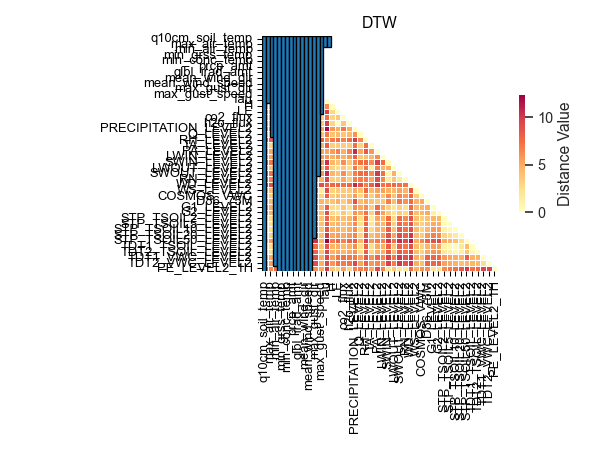

Threshold Num Groups: 100%|██████████| 862/862 [00:00<00:00, 2808.14it/s]


<IPython.core.display.Javascript object>


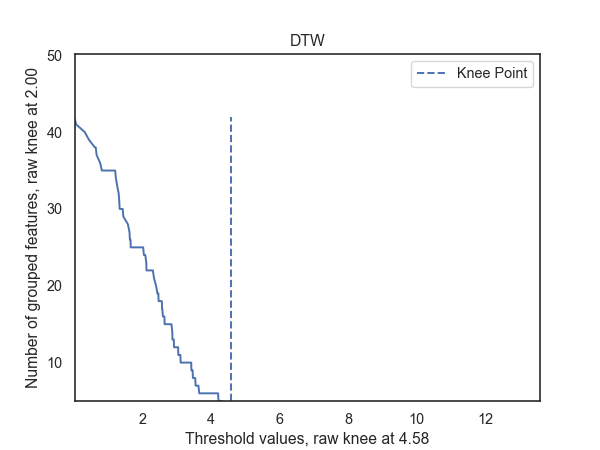

<IPython.core.display.Javascript object>


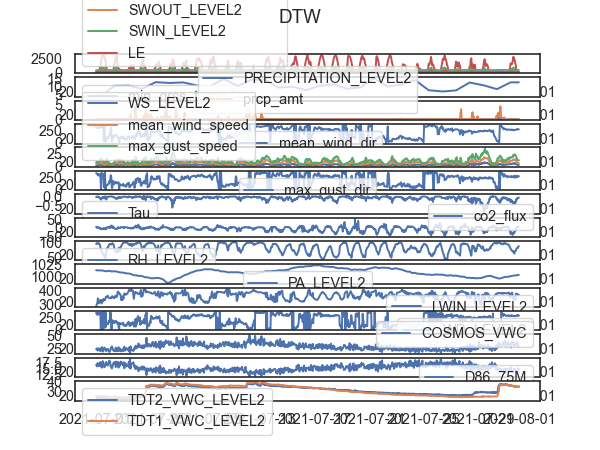

D:\NERC REP 21\NERC REP Repo\NERC-REP\distance_matrix.py:270: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


In [4]:
"""
Run this cell to calculate and plot a distance matrix for df using DTW
Plot generated:
-Heatmap of distance matrix
-Distribution of distance values in distance matrix
-Number of groups against threshold distance values
-Grouped features against time for a chosen number of groups
"""
# Calculates distance matrix and plots heatmap and distribution plots
dtw_mat = distMatrix(normed_df,calcDTWDist)
graphMatrixDistribution(dtw_mat['fullMatrix'],title='DTW')
graphMatrixHeatmap(dtw_mat, title = 'DTW')

# Plots number of groups against threshold values
xs, ys = getThresholdandNumFeaturesLeft(dtw_mat['fullMatrix'])
kn = findKneePoint(xs, ys)
graphThresholdValues(xs, ys, kneePoint=kn,title='DTW')

# Groups columns with threshold = threshold and plots groups, example uses threshold = 2.7 but this value can be changed
featureGrouping = compressMatrixValues(dtw_mat['fullMatrix'], dtw_mat['fullList'], threshold=2.7)
graphFeatureGroupsSubplots(df,featureGrouping,title = 'DTW')

100%|██████████| 42/42 [00:00<00:00, 628.29it/s]


<IPython.core.display.Javascript object>


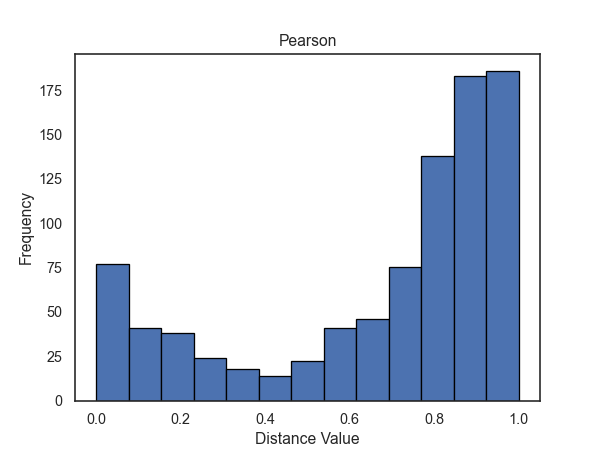

<IPython.core.display.Javascript object>


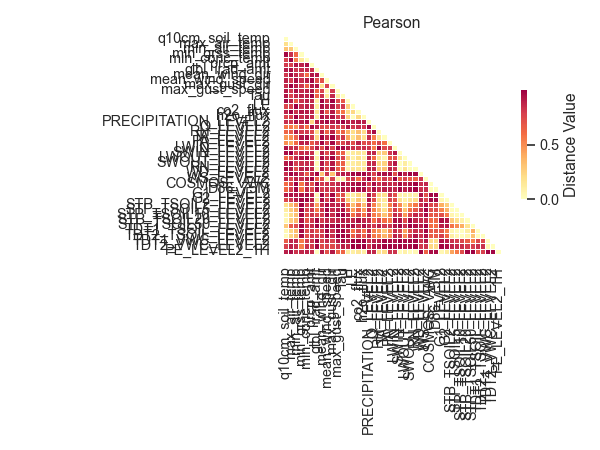

Threshold Num Groups: 100%|██████████| 862/862 [00:00<00:00, 3481.45it/s]


<IPython.core.display.Javascript object>


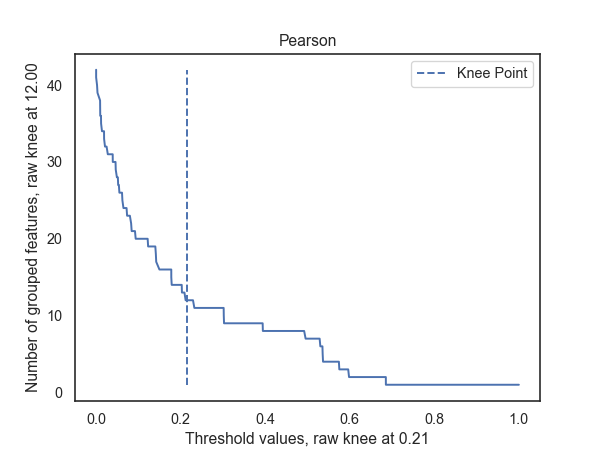

<IPython.core.display.Javascript object>


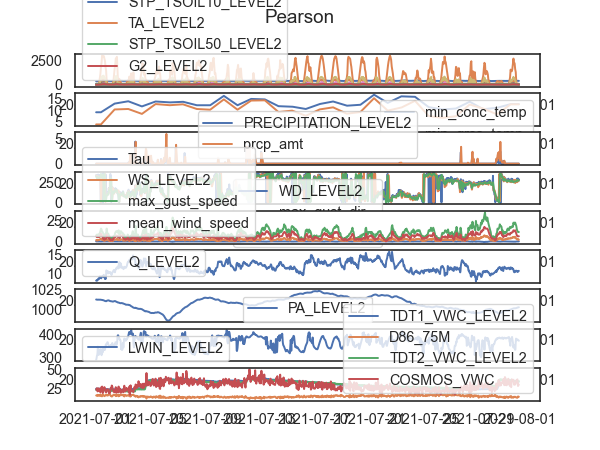

In [7]:
"""
Run this cell to calculate and plot a distance matrix for df using Pearson's correlation coefficient
Plot generated:
-Heatmap of distance matrix
-Distribution of distance values in distance matrix
-Number of groups against threshold distance values
-Grouped features against time for a chosen number of groups
"""

# Calculates distance matrix and plots heatmap and distribution plots
pear_mat = distMatrix(normed_df,pearson)
graphMatrixDistribution(pear_mat['fullMatrix'],title='Pearson')
graphMatrixHeatmap(pear_mat, title = 'Pearson')

# Plots number of groups against threshold values
xs, ys = getThresholdandNumFeaturesLeft(pear_mat['fullMatrix'])
kn = findKneePoint(xs, ys)
graphThresholdValues(xs, ys, kneePoint=kn,title='Pearson')

# Groups columns with threshold = threshold and plots groups, example uses threshold = 0.37 but this value can be changed
featureGrouping = compressMatrixValues(pear_mat['fullMatrix'], pear_mat['fullList'], threshold=0.37)
graphFeatureGroupsSubplots(df,featureGrouping,title = 'Pearson')

100%|██████████| 42/42 [00:00<00:00, 61.38it/s] 


<IPython.core.display.Javascript object>


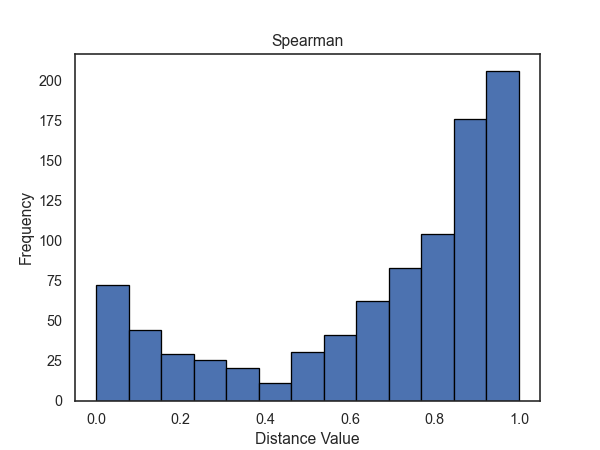

<IPython.core.display.Javascript object>


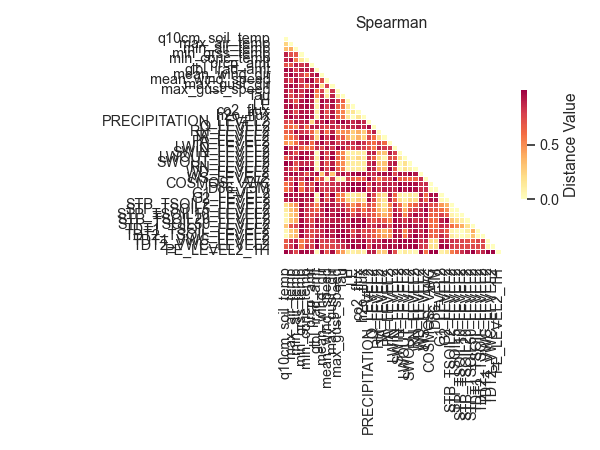

Threshold Num Groups: 100%|██████████| 862/862 [00:00<00:00, 3286.05it/s]


<IPython.core.display.Javascript object>


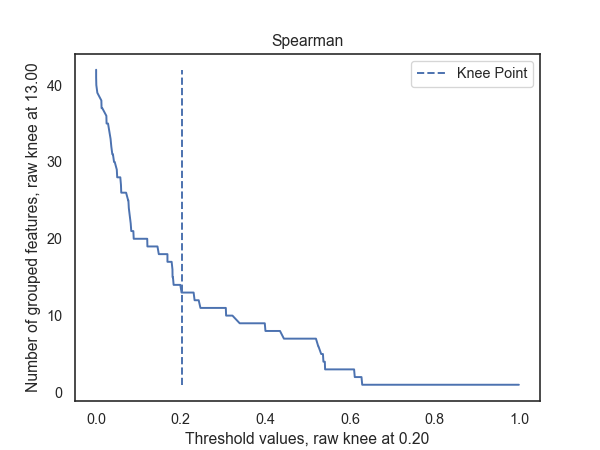

<IPython.core.display.Javascript object>


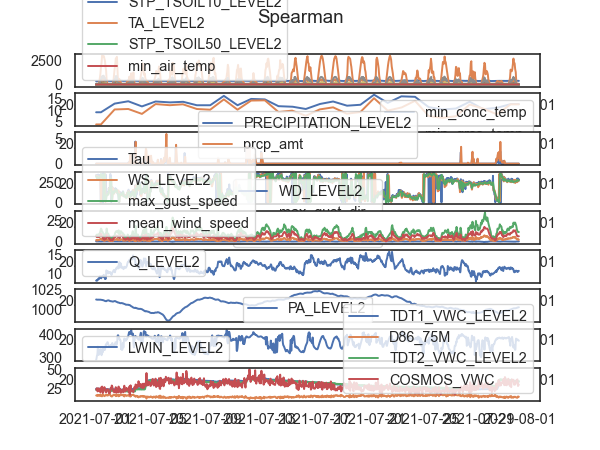

In [9]:
"""
Run this cell to calculate and plot a distance matrix for df using Spearman's rank correlation coefficient
Plot generated:
-Heatmap of distance matrix
-Distribution of distance values in distance matrix
-Number of groups against threshold distance values
-Grouped features against time for a chosen number of groups
"""
# Calculates distance matrix and plots heatmap and distribution plots
spear_mat = distMatrix(normed_df,spearman)
graphMatrixDistribution(spear_mat['fullMatrix'],title='Spearman')
graphMatrixHeatmap(spear_mat, title = 'Spearman')

# Plots number of groups against threshold values
xs, ys = getThresholdandNumFeaturesLeft(spear_mat['fullMatrix'])
kn = findKneePoint(xs, ys)
graphThresholdValues(xs, ys, kneePoint=kn,title='Spearman')

# Groups columns with threshold = threshold and plots groups, example uses threshold = 0.37 but this value can be changed
featureGrouping = compressMatrixValues(spear_mat['fullMatrix'], spear_mat['fullList'], threshold=0.37)
graphFeatureGroupsSubplots(df,featureGrouping,title = 'Spearman')

In [ ]:
"""
Run this cell to do Random Forest Approach 1

This calculates a forecasting importance for each column in df by using every other column to predict every column

Plots generated:
-Bar chart of normalised total importance and normalised total scaled importance for every column and time step
-Above bar chart but with column scores at different time steps summed
"""
# settings

# number of backwards time steps to use when generating features
n_steps = 2

# number of trees to use in random forest
n_trees = 100

# performs Approach 1 and plots results
plot_cols_4_cols_importances(normed_df,n_steps,n_trees)

In [ ]:
"""
Run this cell to perform random forest Approach 2

This calculates a forecasting importance for each column in df by sorting the columns into categories then generating
combinations of columns by taking the n-fold cartesian product of each category. The method of Approach 1 is then used
on each combination and the importances for each column are summed.

Plots generated:
-Bar chart of normalised total importance and normalised total scaled importance for every column and time step
-Above bar chart but with column scores at different time steps summed

WARNING: This cell requires a very high computing on the order of 10s of hours to execute even with low number of trees.
"""
# settings

# number of backwards time steps to use when generating features
n_steps = 2

# number of trees to use in random forest
n_trees = 100


# Columns grouped by sensor type
temp_columns = ['q10cm_soil_temp','max_air_temp','min_air_temp','min_grss_temp','min_conc_temp','TA_LEVEL2',
                'STP_TSOIL2_LEVEL2','STP_TSOIL5_LEVEL2', 'STP_TSOIL10_LEVEL2', 'STP_TSOIL20_LEVEL2',
                'STP_TSOIL50_LEVEL2','TDT1_TSOIL_LEVEL2', 'TDT2_TSOIL_LEVEL2']
wind_speed_columns = ['mean_wind_speed','max_gust_speed','WS_LEVEL2']
wind_dir_columns = ['mean_wind_dir','max_gust_dir','WD_LEVEL2']
rad_columns = ['glbl_irad_amt','LWIN_LEVEL2','SWIN_LEVEL2','LWOUT_LEVEL2','SWOUT_LEVEL2','RN_LEVEL2']
prcp_columns = ['prcp_amt','PRECIPITATION_LEVEL2']
humidity_columns = ['Q_LEVEL2','RH_LEVEL2']
pressure_columns = ['PA_LEVEL2']
heat_flux_columns = ['H','LE','G1_LEVEL2','G2_LEVEL2']
soil_moisture_columns = ['COSMOS_VWC','TDT1_VWC_LEVEL2','TDT2_VWC_LEVEL2']
crns_effective_depth_columns = ['D86_75M']
co2_flux_columns = ['co2_flux']
h2o_flux_columns = ['h2o_flux']
momentum_flux_columns = ['Tau']
potent_evap_columns = ['PE_LEVEL2_1H']

all_column_groups = [temp_columns,wind_speed_columns,wind_dir_columns,rad_columns,prcp_columns,humidity_columns,
                     pressure_columns,heat_flux_columns,soil_moisture_columns,crns_effective_depth_columns,
                     co2_flux_columns, h2o_flux_columns,momentum_flux_columns,potent_evap_columns]


# n-fold cartesian product of each of each category
all_column_groups_combinations = list(itertools.product(*all_column_groups))

# Performs Approach 2 and plots results
# pickle_dfs=True saves the importance dfs from this method, it is recommended to do this due to the long computing time
# so results can be saved after one run then accessed as much as needed.
plot_combi_summed_importances(normed_df, all_column_groups_combinations, n_steps, n_trees, pickle_dfs=True)


In [ ]:
"""
Run this cell to perform Random Forest Approach 3

This allocates the columns of df into n groups using the distance matrix. Random samples of one column from each group
are taken and the forecasting importances for each sample calculated. The sample importances are then summed to give
a forecasting importance score for each group.

Plots generated:
Plots generated:
-Bar chart of normalised total importance and normalised total scaled importance for every column and time step
 for minimum threshold to give n groups
-Above bar chart but with column scores at different time steps summed
-Bar chart of normalised total importance and normalised total scaled importance for every column and time step
 for maximum threshold to give n groups
-Above bar chart but with column scores at different time steps summed
"""
# settings

# number of backwards time steps to use when generating features
n_steps = 2

# number of trees to use in random forest
n_trees = 100

# number of groups to assign columns into
n_groups = 12

# number of random samples to take
n_samples = 50

# Performs Approach 3 and plots results. The members of the groups are also printed
plot_n_groups_importances(df, calcDTWDist,n_groups,n_steps,n_trees,n_samples,use_minThresh=True, use_maxThresh=True)